#### TODO:
- Algo seems to only be off by $100, but that's not much in the crypto world.
- Need to figure out how to make this more useful. 
- Next price point isn't bad, but what's the start? I can make a decent model. Now what?
    - Figure out how to generate the same data, but now estimate it for the next day.

# Use lagged values to predict current price to forecast price
- Notes from this video: https://www.youtube.com/watch?v=xaIA83x5Icg
 - Create separate transformers for features on different scales
 - Use this video for building an initial LSTM model
- Use this video and it's subsequent one for time series forecasting for BTC using binance exchange data: https://www.youtube.com/watch?v=jR0phoeXjrc
    - Use shift to push a column down for matching previous data points to a forecasted point.
    - This video is showing how to prep data for a time series model.
    - This video is for how to take that preprocessed data and put into PyTorch for the LSTM model: https://www.youtube.com/watch?v=ODEGJ_kh2aA&t=107s
         - 

### TODO:
- Now that I'm able to forecast, I need to generate multiple models, and get the mean of all of their estimations a'la a random walk
- Also plot their standard deviations to know the potential variation

In [1993]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import os

In [1994]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [1995]:
import datetime

In [1996]:
import tensorflow as tf
from keras import layers

In [1997]:
from keras import models

In [1998]:
from keras import optimizers

In [1999]:
files = os.listdir(path='.')

In [2000]:
crypto = pd.read_csv('ETH-USD.csv')

In [2001]:
for col in crypto.columns.values:
    crypto.rename(columns={
        col: col.lower()
    }, inplace=True)

In [2002]:
crypto.drop('adj close',axis=1, inplace=True)

In [2003]:
future_estim = 3
output_label = 'next_close_'+str(future_estim)

In [2004]:
crypto[output_label] = crypto['close'].shift(-1*future_estim)

In [2005]:
window_size = 20

In [2006]:
ma = []
upper = []
lower = []
for i in range(window_size):
    ma.append(np.nan)
    upper.append(np.nan)
    lower.append(np.nan)
for row in crypto.iterrows():
    if row[0] < window_size:
        continue
#     print(row[0])
    mean = np.mean(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    ma.append(mean)
    std = np.std(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    upper.append((mean+std*2))
    lower.append((mean-std*2)) 

In [2007]:
len(upper)

1827

In [2008]:
crypto['ma20'] = ma
crypto['upper'] = upper
crypto['lower'] = lower

In [2009]:
crypto.head(20)

,date,open,high,low,close,volume,next_close_3,ma20,upper,lower
0,2016-07-16,11.9194,11.9359,11.59240,11.65280,10445700.0,11.61910,NaN,NaN,NaN
1,2016-07-17,11.6235,11.6703,11.00740,11.15870,17921600.0,12.45060,NaN,NaN,NaN
2,2016-07-18,11.1730,11.6101,10.94830,11.03440,15931900.0,12.65070,NaN,NaN,NaN
3,2016-07-19,11.0466,12.0139,11.01030,11.61910,21730000.0,14.66190,NaN,NaN,NaN
4,2016-07-20,11.5902,12.9914,11.56690,12.45060,60226100.0,14.29970,NaN,NaN,NaN
5,2016-07-21,12.4601,12.7103,11.99370,12.65070,24636900.0,12.74950,NaN,NaN,NaN
6,2016-07-22,12.6575,14.8134,12.53990,14.66190,74779504.0,13.83610,NaN,NaN,NaN
7,2016-07-23,14.6655,14.8989,14.04970,14.29970,32489700.0,11.98950,NaN,NaN,NaN
8,2016-07-24,14.2958,14.4374,12.31610,12.74950,77750800.0,12.97280,NaN,NaN,NaN
9,2016-07-25,12.7434,13.8570,12.68380,13.83610,36673800.0,12.84360,NaN,NaN,NaN


In [2010]:
training_cols = []
for col in crypto.columns.values:
    if 'next' not in col and 'date' not in col and 'adj' not in col:
        training_cols.append(col)

In [2011]:
training_cols

['open', 'high', 'low', 'close', 'volume', 'ma20', 'upper', 'lower']

In [2012]:
og_crypto = crypto.copy()

In [2013]:
crypto = crypto.dropna()

In [2014]:
def train_models(df, label,training_cols, time_steps):
    scaler = StandardScaler()
#     df[label] = scaler.fit_transform(df[[label]])
#     for col in training_cols:
#         df[col] = scaler.transform(df[[col]])
    X = df[training_cols].values
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    output = compare_rg(X_train, y_train, X_test, y_test, time_steps)
    return output, scaler

In [2015]:
def compare_rg(X_train, y_train, X_test, y_test, time_steps):
    classifiers = {
        'XGBR': XGBRegressor(),
#         'NN': neural_net(X_train.shape, time_steps)
    }

    outputs = {
        'XGBR': [],
#         'NN': []
    }
    for model in classifiers:
        if model == 'NN':            
            algo = classifiers[model]
            X_train, y_train = create_dataset(X_train, y_train, time_steps)
            X_test, y_test = create_dataset(X_test, y_test, time_steps)
            algo.fit(X_train, y_train, X_test, y_test)
        else:
            algo = classifiers[model]
            algo.fit(X_train, y_train)
            y_predict = algo.predict(X_test)
            print(" ")
            print(model, ': ',mse(y_test, y_predict))
        for output in outputs:
            if output == model:
                outputs[output] = algo
        print('')
    return outputs

In [2016]:
#https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
class neural_net:
    def __init__(self, shape_input, time_steps):
        self.shape_input = shape_input
        self.model = models.Sequential()
        self.batch_size = 32
        self.model.add(layers.Bidirectional(
            layers.LSTM(units=8, input_shape=(time_steps, shape_input[1]), return_sequences=False)
        ))
        self.model.add(layers.Dropout(0.2, name='dropout_0'))
        self.model.add(layers.Dense(4, activation='relu'))
        self.model.add(layers.Dense(1, activation='relu'))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
#         print(self.model.summary())

    
    def fit(self, X_train, y_train, X_test, y_test):
        self.model.fit(x=X_train, y=y_train, batch_size = self.batch_size, epochs=50, shuffle=False, validation_split=0.1)
        evaluation = self.model.evaluate(X_test, y_test)
        print(evaluation)
    
    def predict(self, Xnew):
        yNew = self.model.predict_classes(Xnew)
        return yNew

In [2017]:
def create_dataset(X, y, time_steps = 20):
    y = y.values
    Xs, ys = [] , []
    for i in range(len(X) - time_steps):
        v = X[i: (i+time_steps)]
        Xs.append(v)
        ys.append(y[(i+time_steps)])
    return np.array(Xs), np.array(ys)

In [2018]:
output, scaler = train_models(crypto, output_label,training_cols, window_size)

 
XGBR :  4102.156079749949



In [2019]:
model = output['XGBR']

In [2020]:
crypto = og_crypto.copy()

In [2021]:
crypto['predicted_close'] = model.predict(crypto[training_cols].values)

In [2022]:
crypto = crypto.tail(50)

In [2023]:
for i in range(future_estim):
    crypto = crypto.append({'date': np.nan}, ignore_index=True)

In [2024]:
dates = []
for date in crypto['date']:
    if date is np.nan:
        prev_date += datetime.timedelta(days=1)
        dates.append(prev_date)
    else:
        date_list = date.split('-')
        date = datetime.datetime(year=int(date_list[0]), month=int(date_list[1]), day=int(date_list[2]))
        dates.append(date)
        prev_date = date

In [2025]:
crypto['date'] = dates

In [2026]:
crypto.dropna(subset=['date'], inplace=True)

In [2027]:
crypto.tail(10)

,date,open,high,low,close,volume,next_close_3,ma20,upper,lower,predicted_close
43,2021-07-10,2146.999756,2190.124023,2081.923584,2111.403564,1.758154e+10,1940.083984,2102.045300,2425.454436,1778.636165,2145.569580
44,2021-07-11,2110.875732,2172.653320,2083.803711,2139.664795,1.470539e+10,1994.331299,2095.297253,2411.940954,1778.653553,1996.184204
45,2021-07-12,2140.506836,2167.710205,2011.018921,2036.721069,1.776813e+10,1911.175659,2107.858118,2410.295656,1805.420579,1908.963135
46,2021-07-13,2034.098389,2040.693604,1922.577881,1940.083984,1.662163e+10,1898.813843,2115.946667,2401.200292,1830.693043,1899.505615
47,2021-07-14,1941.167847,2015.107422,1869.223145,1994.331299,1.734282e+10,NaN,2113.464050,2403.885647,1823.042454,2001.277466
48,2021-07-15,1994.712036,2037.742554,1883.272217,1911.175659,1.568809e+10,NaN,2113.757800,2403.684504,1823.831097,1964.385498
49,2021-07-16,1913.846558,1958.032104,1856.196777,1898.813843,1.518137e+10,NaN,2118.655719,2390.877172,1846.434266,1937.826294
50,2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2028]:
crypto[output_label] = crypto[output_label].shift(future_estim)

In [2029]:
crypto['predicted_close'] = crypto['predicted_close'].shift(future_estim*1)

In [2030]:
crypto.tail(10)

,date,open,high,low,close,volume,next_close_3,ma20,upper,lower,predicted_close
43,2021-07-10,2146.999756,2190.124023,2081.923584,2111.403564,1.758154e+10,2111.403564,2102.045300,2425.454436,1778.636165,2113.144043
44,2021-07-11,2110.875732,2172.653320,2083.803711,2139.664795,1.470539e+10,2139.664795,2095.297253,2411.940954,1778.653553,2142.067871
45,2021-07-12,2140.506836,2167.710205,2011.018921,2036.721069,1.776813e+10,2036.721069,2107.858118,2410.295656,1805.420579,2175.522461
46,2021-07-13,2034.098389,2040.693604,1922.577881,1940.083984,1.662163e+10,1940.083984,2115.946667,2401.200292,1830.693043,2145.569580
47,2021-07-14,1941.167847,2015.107422,1869.223145,1994.331299,1.734282e+10,1994.331299,2113.464050,2403.885647,1823.042454,1996.184204
48,2021-07-15,1994.712036,2037.742554,1883.272217,1911.175659,1.568809e+10,1911.175659,2113.757800,2403.684504,1823.831097,1908.963135
49,2021-07-16,1913.846558,1958.032104,1856.196777,1898.813843,1.518137e+10,1898.813843,2118.655719,2390.877172,1846.434266,1899.505615
50,2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.277466
51,2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1964.385498
52,2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1937.826294


In [2031]:
# y_true = crypto['close'].tolist()
y_forecast = crypto[output_label].tolist()
y_predict = crypto['predicted_close'].tolist()
y_ma = crypto['ma20'].tolist()
y_upper = crypto['upper'].tolist()
y_lower = crypto['lower'].tolist()
x = crypto['date'].tolist()

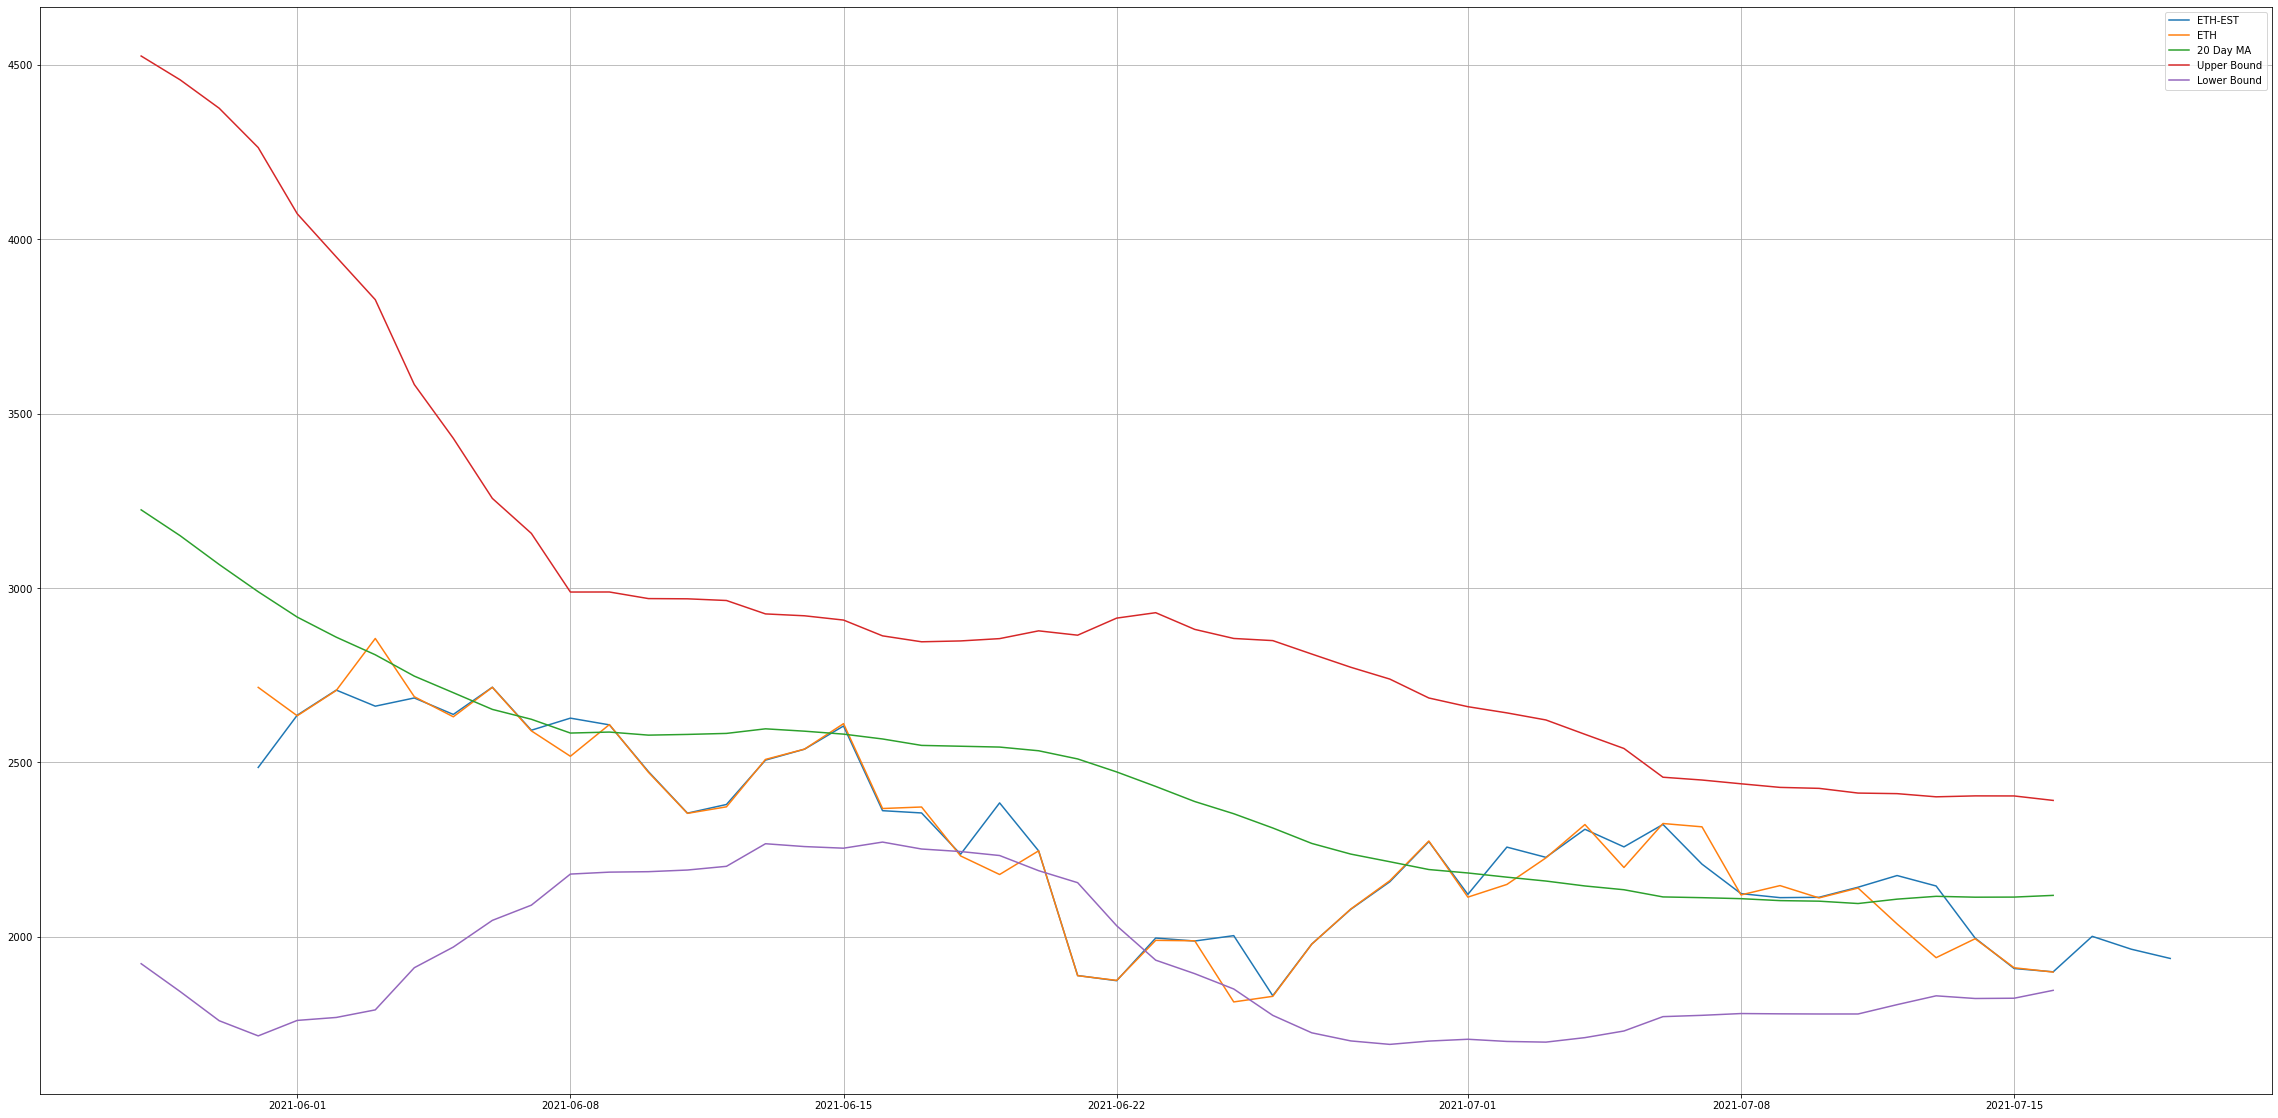

In [2032]:
fig = plt.figure(figsize=(40,20))
plt.plot(x, y_predict, label='ETH-EST')
# plt.plot(x, y_true, label='ETH')
plt.plot(x, y_forecast, label='ETH')
plt.plot(x, y_ma, label='20 Day MA')
plt.plot(x, y_upper, label='Upper Bound')
plt.plot(x, y_lower, label='Lower Bound')
plt.legend()
plt.grid(True)
plt.show()

In [2033]:
training_cols

['open', 'high', 'low', 'close', 'volume', 'ma20', 'upper', 'lower']

In [2034]:
base_url = 'https://api.pro.coinbase.com'

In [2035]:
products = '/products'

In [2036]:
book = '/book?level='

In [2037]:
stats = '/stats'

In [2038]:
#Only shows best bid and ask
level_1 = '1'
#Only shows top 50 bids and asks
level_2 = '2'
#Shows all bids and asks
level_3 = '3'

In [2039]:
curr1 = 'ETH'
curr2 = 'USD'
pair = '/' + curr1 + '-' + curr2

In [2040]:
response = requests.get(base_url+products+pair+stats).json()

In [2041]:
training_cols

['open', 'high', 'low', 'close', 'volume', 'ma20', 'upper', 'lower']

In [2042]:
response

{'open': '1919.27',
 'high': '1965.35',
 'low': '1850.15',
 'volume': '171732.80557635',
 'last': '1899.8',
 'volume_30day': '6755762.02860569'}

In [2043]:
to_eval = pd.DataFrame(response, index=[0])

In [2044]:
to_eval.drop('volume_30day', axis=1, inplace=True)

In [2045]:
to_eval.rename(columns={
    'last': 'close'
},inplace=True)

In [2046]:
to_eval['ma20'] = np.mean(crypto.iloc[(crypto.shape[0]-window_size-1): (crypto.shape[0]-1)]['ma20'])

In [2047]:
to_eval['upper'] = np.std(crypto.iloc[(crypto.shape[0]-window_size-1): (crypto.shape[0]-1)]['ma20'])*2 + np.mean(crypto.iloc[(crypto.shape[0]-window_size-1): (crypto.shape[0]-1)]['ma20'])

In [2048]:
to_eval['lower'] = np.mean(crypto.iloc[(crypto.shape[0]-window_size-1): (crypto.shape[0]-1)]['ma20']) - np.std(crypto.iloc[(crypto.shape[0]-window_size-1): (crypto.shape[0]-1)]['ma20'])*2 

In [2049]:
to_eval

,open,high,low,volume,close,ma20,upper,lower
0,1919.27,1965.35,1850.15,171732.80557635,1899.8,2133.776151,2203.024757,2064.527546


In [2050]:
result = model.predict(to_eval[training_cols].values)

In [2051]:
to_eval['predicted_close'] = result[0]

In [2052]:
crypto = crypto.append(to_eval)

In [2053]:
crypto = crypto.reset_index()

In [2054]:
crypto.tail()

,index,date,open,high,low,close,volume,next_close_3,ma20,upper,lower,predicted_close
49,49,2021-07-16,1913.85,1958.03,1856.2,1898.81,1.51814e+10,1898.813843,2118.655719,2390.877172,1846.434266,1899.505615
50,50,2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.277466
51,51,2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1964.385498
52,52,2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1937.826294
53,0,NaT,1919.27,1965.35,1850.15,1899.8,171732.80557635,NaN,2133.776151,2203.024757,2064.527546,1919.255737
